In [2]:
import os,sys
import torch
import torchvision
import argparse
import tqdm
import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F2
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from datasets import *
from utils import *
from torchvision.models.feature_extraction import create_feature_extractor

In [3]:
import matplotlib.pyplot as plt
import cv2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [4]:
dpath = '/ailab_mat/dataset/ISIC_skin_disease'
# dpath = '/ailab_mat/dataset/ILSVRC/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# def show(imgs):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = F2.to_pil_image(img)
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [6]:
# inputs, _, mask, _ = testset[1]
# np_mask = mask.numpy()

# from scipy import ndimage
# com = ndimage.center_of_mass(np_mask)
# print(com)

# masked_input = inputs * mask
# print(masked_input.shape)

# from torchvision.ops import masks_to_boxes

# boxes = masks_to_boxes(mask)
# print(boxes)
# from torchvision.utils import draw_bounding_boxes

# boxes = boxes.type(torch.uint8)
# mask = (mask*255).type(torch.uint8)
# mask_with_box = draw_bounding_boxes(mask, boxes, colors="red")
# # mask_with_box = (mask_with_box*255).type(torch.uint8)
# show(mask_with_box)

In [7]:
# croped_img = F2.crop(inputs, boxes[0][1],boxes[0][0],boxes[0][3]-boxes[0][1],boxes[0][2]-boxes[0][0])
# print(croped_img.shape)

# plt.figure()
# plt.imshow(croped_img.permute(1,2,0))
# plt.axis(False)

# background = torch.zeros_like(inputs)
# background[:,boxes[0][1]:boxes[0][3],boxes[0][0]:boxes[0][2]] = croped_img
# # print(background[:,boxes[0][0]:boxes[0][2],boxes[0][1]:boxes[0][3]].shape)
# plt.figure()
# plt.imshow(inputs.permute(1,2,0))
# plt.axis(False)
# # plt.imshow(background.permute(1,2,0))

In [8]:
# plt.figure()
# plt.imshow(background.permute(1,2,0))
# plt.axis(False)

In [9]:
# model_path = '/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/HAM10000/seed0/baseline/ACC_77.16.pth'
# # model_path = '/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/isic/seed0/Mask_ALL2_2/ACC_81.33.pth'
# d_path = '/ailab_mat/dataset/ISIC_skin_disease/sample/sample1.jpg'
# # d_path = '/ailab_mat/dataset/ISIC_skin_disease/Test_v2/ISIC-2017_Test_v2_Data/ISIC_0012092.jpg'
# # d_path = '/ailab_mat/dataset/HAM10000/test/mel/ISIC_0034573.jpg'
# # d_path = '/ailab_mat/dataset/HAM10000/train/mel/ISIC_0024310.jpg'

# model = models.resnet50()
# model.fc = nn.Linear(2048, 3)
# return_nodes = {
#             'layer1':'l1',
#             'layer2':'l2',
#             'layer3':'l3',
#             'layer4':'l4',
#             'fc':'fc'
#         }
# model = create_feature_extractor(model, return_nodes=return_nodes)
# model = model.to(device)
# model.load_state_dict(torch.load(model_path))

# image = Image.open(d_path)
# print(image.size)
# width, height = image.size
# IMG = image

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
# transform = transforms.Compose(
#             [transforms.Resize((224,224)),
#             transforms.RandomInvert(p=1.0),
#             transforms.ToTensor(),
#             normalize,
#             ])
# model.eval()
# image = transform(image)
# if image.shape[0] != 1:
#     image = image.unsqueeze(0)
# image = image.to(device)
# print(image.shape)
# outputs = model(image)
# f4 = outputs['l4']
# _, pred = torch.max(outputs['fc'], 1)
# print(f4.shape)
# print(pred.item())

In [10]:
# feat = torch.reshape(f4, [-1,2048,7*7])
# weights = list(model.parameters())[-2]
# weight = weights[int(pred.item())]
# weight = weight.unsqueeze(0).unsqueeze(0)

# cam = torch.bmm(weight, feat)
# cam = torch.reshape(cam, (1,7,7))
# cam = cam-torch.min(cam)
# cam = cam/torch.max(cam)
# # cam = torch.sigmoid(cam)
# cam = cam.unsqueeze(1)
# cam = F.interpolate(cam, size=(height, width), mode='bicubic')
# cam = cam.squeeze()

# print(cam.shape)
# plt.figure()
# plt.imshow(cam.detach().cpu())
# plt.axis(False)

In [11]:
# feat = torch.reshape(f4, [-1,2048,7*7])
# weights = list(model.parameters())[-2]
# caam = torch.zeros((height, width)).to(device)
# for i in range(len(weights)):
#     weight = weights[i]
#     weight = weight.unsqueeze(0).unsqueeze(0)

#     cam = torch.bmm(weight, feat)
#     cam = torch.reshape(cam, (1,7,7))
#     cam = cam-torch.min(cam)
#     cam = cam/torch.max(cam)
#     # cam = torch.sigmoid(cam)
#     cam = cam.unsqueeze(1)
#     cam = F.interpolate(cam, size=(height, width), mode='bicubic')
#     cam = cam.squeeze()
#     caam += cam
# caam = caam-torch.min(caam)
# caam = caam/torch.max(caam)

# print(caam.shape)
# plt.figure()
# plt.imshow(caam.detach().cpu())
# plt.axis(False)

In [12]:
# # print(cam.shape)
# # print(IMG.size)
# np_IMG = np.array(IMG)
# np_caam = cam.detach().cpu().numpy()
# print(np_IMG.shape)
# print(np_caam.shape)
# am = gen_am(image, model)
# print(am.shape)
# am = am.unsqueeze(0).unsqueeze(0)
# am = F.interpolate(am, [450, 600])
# am = am.squeeze()

# print(am.shape)
# refine_am = am + F2.rotate(am.unsqueeze(0).unsqueeze(0), angle=180)
# print(refine_am.shape)
# refine_am = refine_am.squeeze()
# # plt.figure()
# # plt.imshow(IMG)
# # plt.axis(False)

# fig, ax = plt.subplots()
# ax.imshow(IMG)
# ax.imshow(refine_am.detach().cpu(), alpha=0.6)
# ax.axis(False)

In [13]:
# import torchvision.models as models
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models.feature_extraction import create_feature_extractor

# model = models.resnet18()
# train_nodes, eval_nodes = get_graph_node_names(models.resnet18())
# print(train_nodes)
# return_nodes = {
#     'layer1':'layer1',
#     'layer2':'layer2',
#     'layer3':'layer3',
#     'layer4':'layer4',
#     'fc':'fc'
# }
# body = create_feature_extractor(model, return_nodes=return_nodes)

# import torch
# x = torch.randn([2,3,224,224])
# out = body(x)
# print(type(out))
# # print(out['fc'].shape)

In [14]:
# import json

# with open('/ailab_mat/dataset/bdd100k/bdd100k_labels_images_train.json', 'r') as f:
#     train_annot = json.load(f)
    
# for anno in train_annot:
#     if anno['name'] == '5e852617-49aecd0b.jpg':
#         print(anno['labels'])

In [15]:
# import os, sys
# from glob import glob

# filelist = glob('/ailab_mat/dataset/autodriving_korea/daytime/data/Training/source/*.jpg')
# train_list = []
# for name in filelist:
#     if 'left' in name or 'right' in name:
#         continue
#     else:
#         train_list.append(name.split('/')[-1].split('.')[0])
        
# filelist = glob('/ailab_mat/dataset/autodriving_korea/daytime/data/Validation/source/*.jpg')
# val_list = []
# for name in filelist:
#     if 'left' in name or 'right' in name:
#         continue
#     else:
#         val_list.append(name.split('/')[-1].split('.')[0])

# train_list.sort()
# val_list.sort()

# print(len(train_list))
# print(len(val_list))
# print(train_list[:5])
# print(val_list[:5])

In [16]:
# CAM, MASK로 부족한 부분의 Point 생성
# 1. Mask - CAM
# 2. Center of Remain Region
import skimage
import cv2

def get_point(Mask, CAM, tr=0.7):
    assert Mask.shape==CAM.shape 
    binary_cam = CAM.clone()
    binary_cam[binary_cam>=tr] = 1
    binary_cam[binary_cam<tr] = 0
    
    remain = Mask * (1 - binary_cam)
    lbl_0 = skimage.measure.label(remain.detach().cpu().numpy())
    props = skimage.measure.regionprops(lbl_0)
    
    max_contour = None
    max_area = 0
    for prop in props:
        area = prop.area
        if area > max_area:
            max_area = area
            max_contour = prop
            
    cx, cy = max_contour.centroid
    return binary_cam, (cx, cy)

In [281]:
# tensor 형태의 맵을 넣어주면 center를 출력
def get_center_box(map, tr=0.5, mode='all'):
    map = map.clone()
    map[map>=tr]=1
    map[map<tr] = 0
    lbl_0 = skimage.measure.label(map.detach().cpu().numpy())
    props = skimage.measure.regionprops(lbl_0)
    if mode=='all':
        points = []
        boxes = []
        for prop in props:
            cy, cx = prop.centroid
            minr, minc, maxr, maxc = prop.bbox
            boxes.append([minr, minc, maxr-1, maxc-1]) # y_min, x_min, y_max, x_max
            points.append(torch.tensor([cx,cy]))
    if mode=='max':
        points = None
        boxes = None
        area = 0
        for prop in props:
            if prop.area > area:
                area = prop.area
                cy, cx = prop.centroid
                minr, minc, maxr, maxc = prop.bbox
                points = torch.tensor([cx,cy])
                boxes = [minr, minc, maxr, maxc]
    return points, boxes

a = torch.rand((5,5))
a = (a-torch.min(a))/(torch.max(a)-torch.min(a))
a[a>=0.7]=1
a[a<0.7]=0
points, boxes = get_center_box(a)
print(a)
print(points[0].shape)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])
torch.Size([2])


In [314]:
def find_nearest_points(points1, points2): # points1 : Mask, points2 : CAM
    dist_list = torch.cdist(points1, points2, p=2)
    pair_list = []
    for i, dists in enumerate(dist_list):
        idx = torch.argmin(dists)
        pair_list.append(torch.tensor([i, idx])) # idx of points
    return pair_list

a = torch.rand((1,2))
b = torch.rand((4,2))
print(a)
print(b)
c = find_nearest_points(a,b)
print(c)


tensor([[0.1984, 0.2463]])
tensor([[0.7560, 0.7863],
        [0.6403, 0.5549],
        [0.9758, 0.1602],
        [0.8197, 0.6677]])
[tensor([0, 1])]


In [285]:
def gen_pseudo_box(center, bbox):
    # top_left = torch.tensor([bbox[1], bbox[0]], dtype=torch.float) # min_x, min_y
    # top_right = torch.tensor([bbox[3], bbox[0]], dtype=torch.float) # max_x, min_y
    # bottom_left = torch.tensor([bbox[1], bbox[2]], dtype=torch.float) # min_x, max_y
    # bottom_right = torch.tensor([bbox[3], bbox[2]], dtype=torch.float) # max_x, max_y
    top_left = torch.tensor([bbox[1], bbox[0]], dtype=torch.double) # min_x, min_y
    top_right = torch.tensor([bbox[3], bbox[0]], dtype=torch.double) # max_x, min_y
    bottom_left = torch.tensor([bbox[1], bbox[2]], dtype=torch.double) # min_x, max_y
    bottom_right = torch.tensor([bbox[3], bbox[2]], dtype=torch.double) # max_x, max_y
    box_points = torch.stack([top_left,top_right,bottom_left,bottom_right])

    dist_list = torch.cdist(center.unsqueeze(0), box_points)
    box_idx = torch.argmax(dist_list)
    Farthest_point = box_points[box_idx]
    dx = torch.abs(center[0]-Farthest_point[0])
    dy = torch.abs(center[1]-Farthest_point[1])
    cx, cy = center
    minr, minc, maxr, maxc = cy-dy, cx-dx, cy+dy, cx+dx 
    if minr < 0: minr = 0
    if minc < 0: minc = 0
    if maxr > 223: maxr = 223
    if maxc > 223: maxc = 223
    return torch.tensor([minr, minc, maxr, maxc])

# bbox = torch.rand(4)*10
# bbox[2:] = bbox[:2] + bbox[2:]
# print(bbox)
# center = torch.tensor([5.,6.])
# print(gen_pseudo_box(center, bbox))

In [17]:
# img, point, scale로 crop 된 이미지 생성
def get_scaled_cropped_img(img, point, scale=2.0):
    height, width = img.shape[-2], img.shape[-1]
    s_height, s_width = height/scale, width/scale
    lx, rx = int(point[0] - s_width/2), int(point[0] + s_width/2)
    ty, by = int(point[1] - s_height/2), int(point[1] + s_height/2)
    
    if lx <= 0: lx = 0
    if ty <= 0: ty = 0
    if rx >= width: rx = width-1
    if by >= height: by = height-1
    
    scaled_cropped_img = F2.resized_crop(img, ty, lx, by-ty, rx-lx, [height, width])
    # print(scaled_cropped_img.shape)
    return scaled_cropped_img, [ty, lx, by-ty, rx-lx]

In [542]:
def gen_cams(inputs, model):
    inputs = inputs.to(device)
    outputs = model(inputs)
    f4 = outputs['l4']

    height, width = inputs.shape[-2], inputs.shape[-1]
    feat = torch.reshape(f4, [-1,2048,7*7])
    weights = list(model.parameters())[-2]
    biases = list(model.parameters())[-1]
    cams = []
    for i in range(len(weights)):
        weight = weights[i]
        bias = biases[i]
        weight = weight.unsqueeze(0).unsqueeze(0)
        cam = torch.bmm(weight, feat)
        # print(cam.shape)
        cam = torch.reshape(cam, (1,7,7))
        cam = cam.unsqueeze(1)
        cam = F.interpolate(cam, size=(height, width), mode='bicubic')
        cam = cam-torch.min(cam)
        cam = cam/torch.max(cam)
        # cam = cam.squeeze()
        cams.append(cam)
    cams = torch.stack(cams)
    cams = cams.squeeze()
    return cams

def gen_softmax_cams(inputs,model):
    inputs = inputs.to(device)
    outputs = model(inputs)
    f4 = outputs['l4']

    height, width = inputs.shape[-2], inputs.shape[-1]
    feat = torch.reshape(f4, [-1,2048,7*7])
    weights = list(model.parameters())[-2]
    biases = list(model.parameters())[-1]
    cams = []
    for i in range(len(weights)):
        weight = weights[i]
        bias = biases[i]
        weight = weight.unsqueeze(0).unsqueeze(0)
        cam = torch.bmm(weight, feat)
        # print(cam.shape)
        cam = torch.reshape(cam, (1,7,7))
        cam = cam.unsqueeze(1)+bias
        cam = F.interpolate(cam, size=(height, width), mode='bicubic')
        cam = torch.softmax(cam, dim=-1)
        # cam = cam.squeeze()
        cams.append(cam)
    cams = torch.stack(cams)
    cams = cams.squeeze()
    return cams

def spatial_cls_prediction(inputs, model):
    

In [19]:
# Activation map
def gen_am(inputs, model, device):
    # model.eval()
    inputs = inputs.to(device)
    outputs = model(inputs)
    f4 = outputs['l4']
    # print(f4.shape)
    height, width = inputs.shape[-2], inputs.shape[-1]
    
    AM = torch.avg_pool1d(f4.squeeze().permute(1,2,0), 2048)
    AM = AM.squeeze()
    AM = AM.unsqueeze(0).unsqueeze(0)
    AM = F.interpolate(AM, size=(height, width), mode='bilinear')
    
    AM = torch.softmax(AM, dim=-1)
    AM = AM-torch.min(AM)
    AM = AM/torch.max(AM)
    
    AM = AM.squeeze()
    # print(AM.shape)
    return AM

In [20]:
# zoom된 caam을 기존 caam에 concat하여 하나로 합침
def concat_ams(caams, boxes, point):
    height, width = caams[0].shape[-2], caams[0].shape[-1]
    final_caam = torch.zeros([height, width]).to(device)
    for box, caam in zip(boxes, caams):
        h, w = box[2], box[3]
        caam = F2.resize(caam.unsqueeze(0).unsqueeze(0), [h, w])
        caam = caam.squeeze()
        final_caam[box[0]:box[0]+box[2], box[1]:box[1]+box[3]] += caam
        # final_caam[box[0]:box[0]+box[2], box[1]:box[1]+box[3]] /= 1.0
        final_caam = torch.clamp(final_caam, min=0, max=1.0)
    # final_caam = torch.softmax(final_caam, dim=-1)
    # final_caam = final_caam-torch.min(final_caam)
    # final_caam = final_caam/torch.max(final_caam)
    # final_caam = torch.sigmoid(final_caam)
    return final_caam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.4015, 0.4109, 0.4487, 0.4537, 0.4024, 0.4044, 0.3915],
        [0.5711, 0.4189, 0.8845, 0.6146, 0.4826, 0.4669, 0.4556],
        [0.5424, 1.0000, 0.5126, 0.5285, 0.6091, 0.0000, 0.3692],
        [0.4361, 0.5447, 0.4874, 0.4041, 0.1921, 0.5760, 0.4182],
        [0.4630, 0.5356, 0.6370, 0.5795, 0.4218, 0.9681, 0.4201],
        [0.5854, 0.4773, 0.5547, 0.5103, 0.5444, 0.6315, 0.4248],
        [0.5228, 0.4261, 0.4964, 0.4244, 0.4375, 0.4408, 0.4032]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
(tensor(3, device='cuda:0'), tensor(4, device='cuda:0'))
tensor(0.5795, device='cuda:0', grad_fn=<SelectBackward0>)
label :  0
pred :  0


(-0.5, 223.5, 223.5, -0.5)

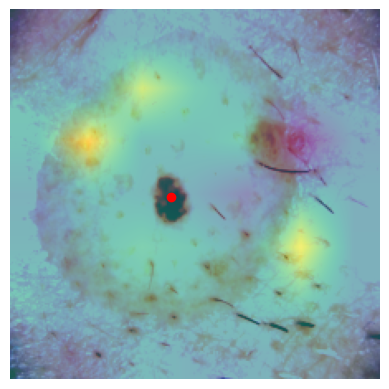

In [183]:
dpath = '/ailab_mat/dataset/ISIC_skin_disease/balanced/'
testset = ISIC2017(dpath, 'test')
# dpath = '/ailab_mat/dataset/HAM10000'
# testset = HAM10000(dpath, 'test')
testloader = DataLoader(testset, 1, shuffle=False, num_workers=4)
# _,_,M,_ = next(iter(testloader))
# print(M.shape)
inputs, labels, mask, _ = testset[248]
inputs = inputs.unsqueeze(0)
mask = mask.squeeze()
mask = mask.to(device)

model = models.resnet50()
model.fc = nn.Linear(2048, 3)

return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model = create_feature_extractor(model, return_nodes=return_nodes)
model = model.to(device)
# model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/HAM10000/seed0/baseline/model_65.33.pth'))
model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/balanced_HAM10000/seed0/ActivationMatching/base_fully/ACC_67.78.pth'))

model.eval()
# print(inputs.shape)
outputs = model(inputs.to(device))
feat = outputs['l4']
outputs = outputs['fc']

cams = gen_cams(inputs, model)
print(cams[labels])
cam_label = cams[labels].clone()
# print(cam_label.shape)

cam_vis = F.interpolate(cams[labels].unsqueeze(0).unsqueeze(0),size=(224,224),mode='bilinear').squeeze()
enc_mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0),size=(7,7),mode='nearest').squeeze()
# _, center = get_point(mask, cam_vis, tr=0.5)
print(enc_mask)
# print(cam_label)
point_score = (enc_mask*cam_label)
point_score[point_score==0]=1
# print(point_score)
min_point_idx = torch.argmin(point_score)
enc_center = (min_point_idx%7,min_point_idx//7)

_, center = get_point(mask, cam_vis, tr=0.5)
# enc_center = [int(center[0]*7/224.0), int(center[1]*7/224.0)]
print(enc_center)
print(cam_label[enc_center[1], enc_center[0]])

print('label : ', labels)
print('pred : ', torch.max(outputs, 1)[1].item())
fig, ax = plt.subplots()
ax.imshow(inputs.squeeze().permute(1,2,0).detach().cpu())
ax.imshow(cam_vis.detach().cpu(), alpha=0.6)
# ax.imshow(mask.detach().cpu(), alpha=0.6)
ax.plot([center[0]], center[1], 'ro')
ax.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224])
torch.Size([224, 224])
tensor(0.0178, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MinBackward1>)
tensor([ 44.7473,  39.7796, 135.0000, 151.0000], dtype=torch.float64)
labels :  2
preds :  2


(-0.5, 223.5, 223.5, -0.5)

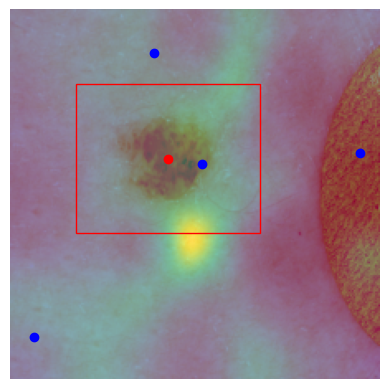

In [554]:
import matplotlib.patches as patches

dpath = '/ailab_mat/dataset/ISIC_skin_disease/balanced/'
# testset = ISIC2017(dpath, 'test')
testset = ISIC2017(dpath, 'train')
testloader = DataLoader(testset, 1, shuffle=False, num_workers=4)
inputs, labels, mask, _ = testset[155]
inputs = inputs.unsqueeze(0)
mask = mask.squeeze()
mask = mask.to(device)
model = models.resnet50()
model.fc = nn.Linear(2048, 3)
return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model = create_feature_extractor(model, return_nodes=return_nodes)
model = model.to(device)

model2 = models.resnet50()
model2.fc = nn.Linear(2048, 3)
return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model2 = create_feature_extractor(model2, return_nodes=return_nodes)
model2 = model2.to(device)

model2.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/balanced_HAM10000/seed0/PointMatching/baseline/ACC_78.22.pth'))
# model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/balanced_HAM10000/seed0/PointMatching/baseline/ACC_78.22.pth'))
model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/balanced_HAM10000/seed0/PointMatching/box_matching_fully/model.pth'))
model.train()
model2.eval()

outputs = model(inputs.to(device))
feat = outputs['l4']
outputs = outputs['fc']
_, pred = torch.max(outputs, dim=1)
pred = pred.item()

outputs2 = model2(inputs.to(device))
outputs2 = outputs2['fc']
_, pred2 = torch.max(outputs2, dim=1)
pred2 = pred2.item()

cams = gen_cams(inputs, model)
softmax_cams = gen_softmax_cams(inputs,model)

cam = cams[pred]
soft_cam = softmax_cams[pred]
# cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224,224), mode='bicubic').squeeze()
print(cam.shape)
print(soft_cam.shape)
print(torch.max(soft_cam))
print(torch.min(soft_cam))

cams2 = gen_cams(inputs, model2)
cam2 = cams2[pred2]
# cam2 = F.interpolate(cam2.unsqueeze(0).unsqueeze(0), size=(224,224), mode='bicubic').squeeze()

m_point, m_box = get_center_box(mask, mode='max')
# m_point = m_point[0]
# print(m_point)
c_points, c_boxes = get_center_box(cam2, tr=0.5)
points_pair = find_nearest_points(m_point.unsqueeze(0), torch.stack(c_points))
# print(points_pair)
s_cam_point, s_cam_box = c_points[points_pair[0][1]], c_boxes[points_pair[0][1]]
# print(s_cam_point)
pseudo_box = gen_pseudo_box(m_point, s_cam_box)
# pseudo_box = pseudo_box.item()
print(pseudo_box)
print("labels : ",labels)
print("preds : ", pred)

cam_lbl = torch.zeros_like(cam2)
cam_lbl[int(pseudo_box[0]):int(pseudo_box[2]),int(pseudo_box[1]):int(pseudo_box[3])] = 1.

fig, ax = plt.subplots()
ax.imshow(inputs.squeeze().permute(1,2,0).detach().cpu())
ax.imshow(soft_cam.detach().cpu(), alpha=0.6)
# ax.imshow(mask.detach().cpu(), alpha=0.6)
bbox = patches.Rectangle((pseudo_box[1],pseudo_box[0]), pseudo_box[3]-pseudo_box[1], pseudo_box[2]-pseudo_box[0],linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(bbox)
ax.plot([m_point[0]], m_point[1], 'ro')
for point in c_points:
    ax.plot([point[0]],point[1], 'bo')
ax.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.0345, 0.0311, 0.0865, 0.2433, 0.1679, 0.1371, 0.0150],
        [0.0228, 0.0975, 0.0744, 0.0831, 1.0000, 0.0294, 0.0302],
        [0.1188, 0.0624, 0.0491, 0.4218, 0.8458, 0.3725, 0.0364],
        [0.0259, 0.0273, 0.0195, 0.4989, 0.2486, 0.1871, 0.0242],
        [0.0140, 0.0934, 0.0767, 0.4260, 0.2758, 0.1816, 0.0306],
        [0.0768, 0.0887, 0.5377, 0.0138, 0.3187, 0.0893, 0.0096],
        [0.1186, 0.0790, 0.0000, 0.1114, 0.0876, 0.3044, 0.0163]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AsStridedBackward0>)
(126.57163877138127, 119.62442523450433)
[3, 3]
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
  

(-0.5, 223.5, 223.5, -0.5)

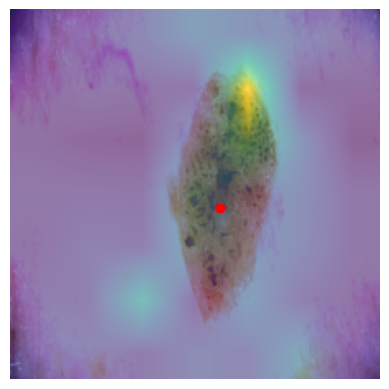

In [61]:
dpath = '/ailab_mat/dataset/ISIC_skin_disease/balanced/'
testset = ISIC2017(dpath, 'test')
# dpath = '/ailab_mat/dataset/HAM10000'
# testset = HAM10000(dpath, 'test')
testloader = DataLoader(testset, 1, shuffle=False, num_workers=4)
inputs, labels, mask, _ = testset[222]
inputs = inputs.unsqueeze(0)
mask = mask.squeeze()
mask = mask.to(device)

model = models.resnet50()
model.fc = nn.Linear(2048, 3)

return_nodes = {
            'layer1':'l1',
            'layer2':'l2',
            'layer3':'l3',
            'layer4':'l4',
            'fc':'fc'
        }
model = create_feature_extractor(model, return_nodes=return_nodes)
model = model.to(device)
# model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/HAM10000/seed0/baseline/model_65.33.pth'))
model.load_state_dict(torch.load('/ailab_mat/personal/heo_yunjae/supervision_active_learning/ask_for_help/parameters/balanced_HAM10000/seed0/base_fully/ACC_67.78.pth'))

model.eval()
# print(inputs.shape)
outputs = model(inputs.to(device))
feat = outputs['l4']
outputs = outputs['fc']

mean_feat = torch.mean(feat, dim=1)
# mean_feat = mean_feat.unsqueeze(0)
# mean_feat = F.interpolate(mean_feat, size=(5,5), mode='bilinear')
# mean_feat = torch.sigmoid(mean_feat)
min_max_norm_feat = (mean_feat - torch.min(mean_feat))/(torch.max(mean_feat) - torch.min(mean_feat))
# min_max_norm_feat = torch.sigmoid(min_max_norm_feat)
min_max_norm_feat = min_max_norm_feat.squeeze()
print(min_max_norm_feat)

min_max_norm_feat[min_max_norm_feat>0.5] = 1
min_max_norm_feat[min_max_norm_feat<0.5] = 0
print(min_max_norm_feat)
# print(min_max_norm_feat.shape)

# _, pred = torch.max(outputs, 1)
# print("Label : ", labels)
# print("Pred : ", pred.item())


am = gen_am(inputs, model, device)
bn_cam, center = get_point(mask, am, tr=0.5)

print(center)
encoded_center = [int(center[0]*7/224.0), int(center[1]*7/224.0)]
print(encoded_center)
min_max_norm_feat[encoded_center[1], encoded_center[0]] = 1
print(min_max_norm_feat)

# scaled_cropped_img_2x, box_2x = get_scaled_cropped_img(inputs, center, scale=1.2)
# scaled_cropped_img_3x, box_3x = get_scaled_cropped_img(inputs, center, scale=1.6)
# scaled_cropped_img_4x, box_4x = get_scaled_cropped_img(inputs, center, scale=2.0)

# scaled_caam_2x = gen_am(scaled_cropped_img_2x, model, device)
# scaled_caam_3x = gen_am(scaled_cropped_img_3x, model, device)
# scaled_caam_4x = gen_am(scaled_cropped_img_4x, model, device)

# box_1x = [0,0,inputs.shape[2]-1,inputs.shape[3]-1]

# caams = [am, scaled_caam_2x,scaled_caam_3x, scaled_caam_4x]
# boxes = [box_1x,box_2x,box_3x, box_4x]

# concated_am = concat_ams(caams, boxes, device)
# # print(concated_am.shape)
# meanAvgPool = nn.AvgPool2d(2,2)
# concated_am = meanAvgPool(concated_am.unsqueeze(0).unsqueeze(0)).squeeze()
# concated_am = meanAvgPool(concated_am.unsqueeze(0).unsqueeze(0)).squeeze()
# concated_am = meanAvgPool(concated_am.unsqueeze(0).unsqueeze(0)).squeeze()
# concated_am = F.interpolate(concated_am.unsqueeze(0).unsqueeze(0), scale_factor=8.0, mode='bilinear').squeeze()
# # print(concated_am.shape)

fig, ax = plt.subplots()
ax.imshow(inputs.squeeze().permute(1,2,0).detach().cpu())
# ax.imshow(scaled_cropped_img_2x.squeeze().permute(1,2,0).detach().cpu())

ax.imshow(am.detach().cpu(), alpha=0.6)
# ax.imshow(scaled_caam_2x.detach().cpu(), alpha=0.5)
# ax.imshow(concated_am.detach().cpu(), alpha=0.5)

# ax.imshow(mask.detach().cpu(), alpha=0.6)
ax.plot([center[0]], center[1], 'ro')
ax.axis(False)

In [48]:
a = torch.randn([2,2])
a = (a-torch.min(a)) / (torch.max(a)-torch.min(a))
print(a)
b = torch.tensor([[1.,0.],[0.,1.]])
print(b)
BCE = torch.nn.BCELoss()
print(BCE(a,b))
MSE = nn.MSELoss()
print(MSE(a,b))
L1 = nn.L1Loss()
print(L1(a,b))

tensor([[1.0000, 0.3936],
        [0.0000, 0.7284]])
tensor([[1., 0.],
        [0., 1.]])
tensor(0.2043)
tensor(0.0572)
tensor(0.1663)


In [150]:
a = torch.rand(4,7,7)
b = [torch.tensor([torch.argmin(s)%7,torch.argmin(s)//7]) for s in a]
print(b)

[tensor([2, 6]), tensor([2, 1]), tensor([2, 1]), tensor([0, 1])]
